In [1]:
#Importamos las librerías necesarias
import pandas as pd
import re
import numpy as np 
import pandas as pd

In [2]:
df =  pd.read_csv("International football results from 1872 to 2022/results.csv")

In [3]:
df["date"] = pd.to_datetime(df["date"])

In [4]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [5]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [6]:
df.dropna(inplace=True)
df.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

El conjunto de datos utilizado serán los partidos de la FIFA entre 2018, desde después de la Copa del Mundo de 2018 hasta los últimos partidos antes de la Copa del Mundo de 2022. La idea es analizar solo los partidos jugados en la preparación y clasificación a WC.

In [7]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
44366,2023-01-12,Sweden,Iceland,2,1,Friendly,Faro-Loulé,Portugal,True
44367,2023-01-25,United States,Serbia,1,2,Friendly,Los Angeles,United States,False
44368,2023-01-28,United States,Colombia,0,0,Friendly,Carson,United States,False
44369,2023-02-22,Grenada,Barbados,1,1,Friendly,Sauteurs,Grenada,False
44370,2023-02-26,Grenada,Barbados,2,2,Friendly,St. George's,Grenada,False


In [8]:
df = df[(df["date"] >= "2018-8-1")].reset_index(drop=True)
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
3940,2023-01-12,Sweden,Iceland,2,1,Friendly,Faro-Loulé,Portugal,True
3941,2023-01-25,United States,Serbia,1,2,Friendly,Los Angeles,United States,False
3942,2023-01-28,United States,Colombia,0,0,Friendly,Carson,United States,False
3943,2023-02-22,Grenada,Barbados,1,1,Friendly,Sauteurs,Grenada,False
3944,2023-02-26,Grenada,Barbados,2,2,Friendly,St. George's,Grenada,False


In [9]:
df.home_team.value_counts()

United States               48
Mexico                      43
Qatar                       43
Japan                       42
United Arab Emirates        39
                            ..
Bhutan                       1
Tonga                        1
Alderney                     1
Saint Helena                 1
Northern Mariana Islands     1
Name: home_team, Length: 247, dtype: int64

In [10]:
rank = pd.read_csv("FIFA World Ranking 1992-2022/fifa_ranking-2022-12-22.csv")

rank["rank_date"] = pd.to_datetime(rank["rank_date"])

rank = rank[(rank["rank_date"] >= "2018-8-1")].reset_index(drop=True)

Algunos equipos de la Copa del Mundo tienen nombres diferentes en el conjunto de datos de la clasificación. Por lo tanto, es necesario ajustar.

In [11]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

La fusión se realiza con el fin de obtener un conjunto de datos de juegos de la FIFA y sus clasificaciones.

In [12]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [13]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [14]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
2896,2022-03-29,Bolivia,Brazil,0,4,FIFA World Cup qualification,La Paz,Bolivia,False,1308.12,1324.21,76.0,-1.0,1823.42,1826.35,2.0,0.0
2988,2022-06-02,South Korea,Brazil,1,5,Friendly,Seoul,South Korea,False,1519.54,1522.85,29.0,0.0,1832.69,1823.42,1.0,-1.0
3056,2022-06-06,Japan,Brazil,0,1,Friendly,Tokyo,Japan,False,1553.44,1549.82,23.0,0.0,1832.69,1823.42,1.0,-1.0
3234,2022-09-23,Brazil,Ghana,3,0,Friendly,Le Havre,France,True,1837.56,1837.56,1.0,0.0,1393.47,1389.68,60.0,0.0
3302,2022-09-27,Brazil,Tunisia,5,1,Friendly,Paris,France,True,1837.56,1837.56,1.0,0.0,1507.86,1507.86,30.0,0.0
3438,2022-11-24,Brazil,Serbia,2,0,FIFA World Cup,Lusail,Qatar,True,1841.30,1837.56,1.0,0.0,1563.62,1549.53,21.0,-4.0
3454,2022-11-28,Brazil,Switzerland,1,0,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1635.92,1621.43,15.0,-1.0
3470,2022-12-02,Cameroon,Brazil,1,0,FIFA World Cup,Lusail,Qatar,True,1471.44,1484.95,43.0,5.0,1841.30,1837.56,1.0,0.0
3478,2022-12-05,Brazil,South Korea,4,1,FIFA World Cup,Doha,Qatar,True,1841.30,1837.56,1.0,0.0,1530.30,1526.02,28.0,0.0
3481,2022-12-09,Croatia,Brazil,1,1,FIFA World Cup,Al Rayyan,Qatar,True,1645.64,1632.15,12.0,-3.0,1841.30,1837.56,1.0,0.0


Ahora, tenemos los datos listos para crear características basadas en los resultados de los partidos y las clasificaciones de la FIFA.

Lo ideal sería crear posibles características que tengan impacto en la predicción de los partidos de fútbol. Podemos decir que las características que impactan pueden ser:

- Puntos obtenidos en partidos anteriores
- Goles marcados y sufridos en el pasado
- La importancia del partido (amistoso o no)
- Clasificación de los equipos
- Incremento de la clasificación de los equipos
- Goles hechos y sufridos por ranking enfrentado
Por lo tanto, lo primero que hay que hacer es crear la función que diga qué equipo ganó y cuántos puntos hizo en el partido.

In [15]:
df = df_wc_ranked

In [16]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

df[["result", "home_team_points", "away_team_points"]] = results

Los puntos de juego son 3 por victoria, 1 por empate y 0 por derrota y son diferentes a los puntos del Ranking FIFA que ya están en la base de datos. Además, se supone que los puntos de clasificación FIFA y la clasificación FIFA del mismo equipo están correlacionados negativamente, y deberíamos utilizar sólo uno de ellos para crear nuevas características. Esta suposición se comprueba a continuación:

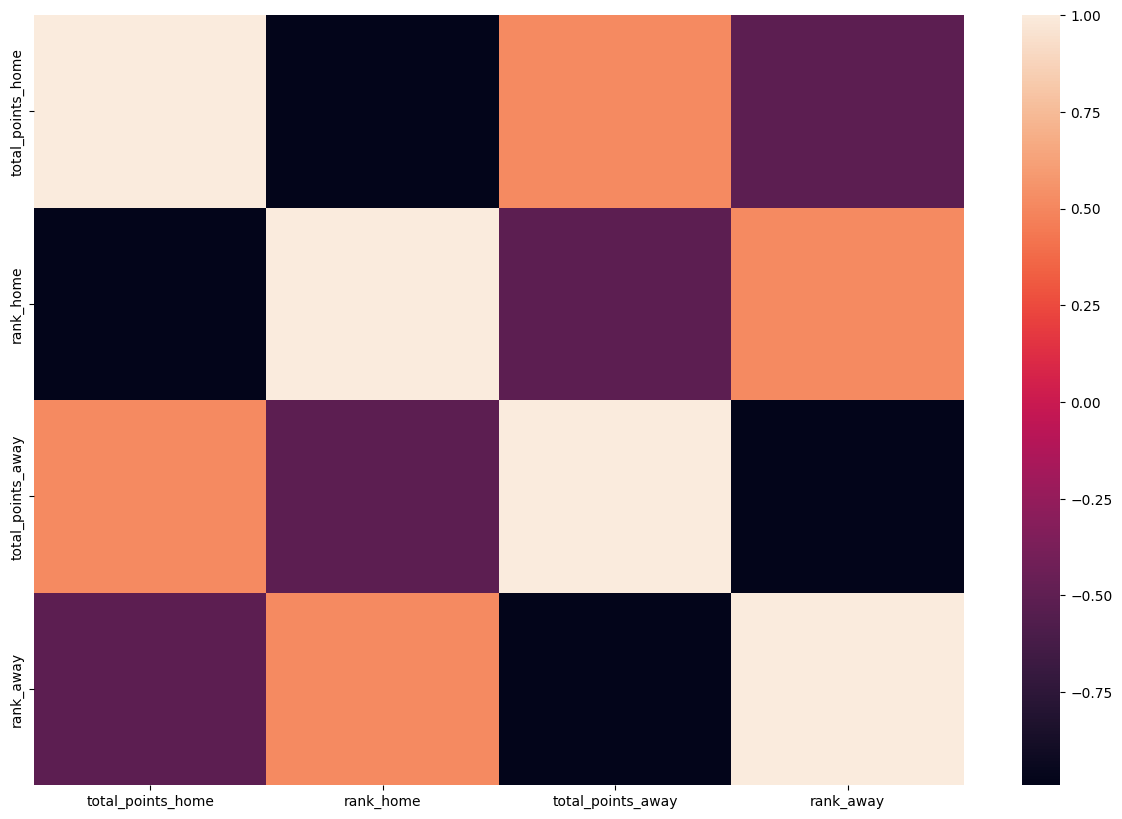

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

Ahora, creamos las columnas que nos ayudarán en la creación de las características: - diferencia en la clasificación, - puntos ganados en el partido vs. clasificación del equipo enfrentado, y - diferencia de goles en el partido. Todas las características que sean diferentes deben crearse para los dos equipos (visitante y local).

In [18]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

Para crear las características, se debe separar el conjunto de datos en equipo local y equipo visitante Luego se unirán y se calcularán los valores de los partidos anteriores. A continuación, se separan de nuevo y se vuelven a fusionar, recuperando el conjunto de datos original. Este proceso optimiza la creación de las características.

In [19]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [20]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [21]:
team_stats = home_team.append(away_team)

C:\Users\angel\AppData\Local\Temp\ipykernel_10552\2656291173.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)


In [22]:
#Esta columna se utilizará para calcular las características para la simulación

team_stats_raw = team_stats.copy()


Se tiene una base de datos lista para crear las características predictivas. Estas serán:

- Media de goles del equipo en el Ciclo de la Copa del Mundo.
- Media de goles del equipo en los últimos 5 partidos.
- Media de goles sufridos por el equipo en el Ciclo de la Copa del Mundo.
- Media de goles sufridos por el equipo en los últimos 5 partidos.
- Clasificación FIFA media a la que se enfrentó el equipo en el Ciclo de la Copa Mundial.
- Clasificación FIFA media del equipo en los últimos 5 partidos.
- Puntos FIFA ganados en el ciclo.
- Puntos FIFA ganados en los últimos 5 partidos.
- Media de puntos de juego en el ciclo.
- Media de puntos de juego en los últimos 5 partidos.
- Media de puntos de juego por rango al que se enfrentó el equipo en el ciclo.
- Media de puntos por rango en los últimos 5 partidos.

In [23]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [24]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [25]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [26]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [27]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Para unificar la base de datos, es necesario añadir el sufijo home y away a cada columna. Después de eso, los datos están listos para ser fusionados

In [28]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [29]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [30]:
#se cuantifica la importancia del juego creando una columna que encuentra la competencia de dicho juego.

def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [31]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [32]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
3489,2022-12-14,Malaysia,Maldives,146.0,154.0,3,0,0,-8.0,-2.0,...,1.789474,1.6,0.011980,0.010218,1.307692,1.8,0.007591,0.009363,0,1
3490,2022-12-14,Vietnam,Philippines,96.0,133.0,1,0,0,-37.0,-1.0,...,1.611111,2.0,0.013659,0.022238,1.000000,0.8,0.006534,0.004550,0,1
3491,2022-12-17,Croatia,Morocco,12.0,22.0,2,1,0,-10.0,-3.0,...,1.636364,1.2,0.106002,0.322967,2.104167,2.0,0.074431,0.409872,1,0
3492,2022-12-17,Singapore,Maldives,160.0,154.0,3,1,0,6.0,1.0,...,1.379310,1.0,0.009629,0.007240,1.259259,1.8,0.007310,0.009363,0,1
3493,2022-12-18,Argentina,France,3.0,4.0,3,3,2,-1.0,0.0,...,2.232143,2.6,0.136649,0.160020,2.166667,2.4,0.175278,0.230350,1,0


In [33]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  101
home_goals_mean_l5               101
home_goals_suf_mean              101
home_goals_suf_mean_l5           101
home_rank_mean                   101
home_rank_mean_l5                101
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  100
away_goals_mean_l5               100
away_goals_suf_mean              100
away_goals_suf_mean_l5           100
away_rank_mean                   100
away_rank_mean_l5                100
away_points_mean                   0
away_points_mean_l5                0
h

In [34]:
base_df_no_fg = base_df.dropna()

Análisis de datos

Ahora se tienen que analizar todas las características creadas y comprobar si tienen poder predictivo. Además, si no lo tienen, se tendrán que crear algunas que lo tengan, como las diferencias de los equipos local y visitante. Para analizar el poder predictivo, se le asignará a los partidos empatados el valor de una derrota del equipo local y se creará un problema binario.

In [35]:
df = base_df_no_fg

def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\angel\AppData\Local\Temp\ipykernel_10552\1284309440.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


Análisis que se realizarán:

Violín y boxplot para analizar si las características tienen distribuciones diferentes según el objetivo.
Gráficos de dispersión para analizar correlaciones

In [36]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

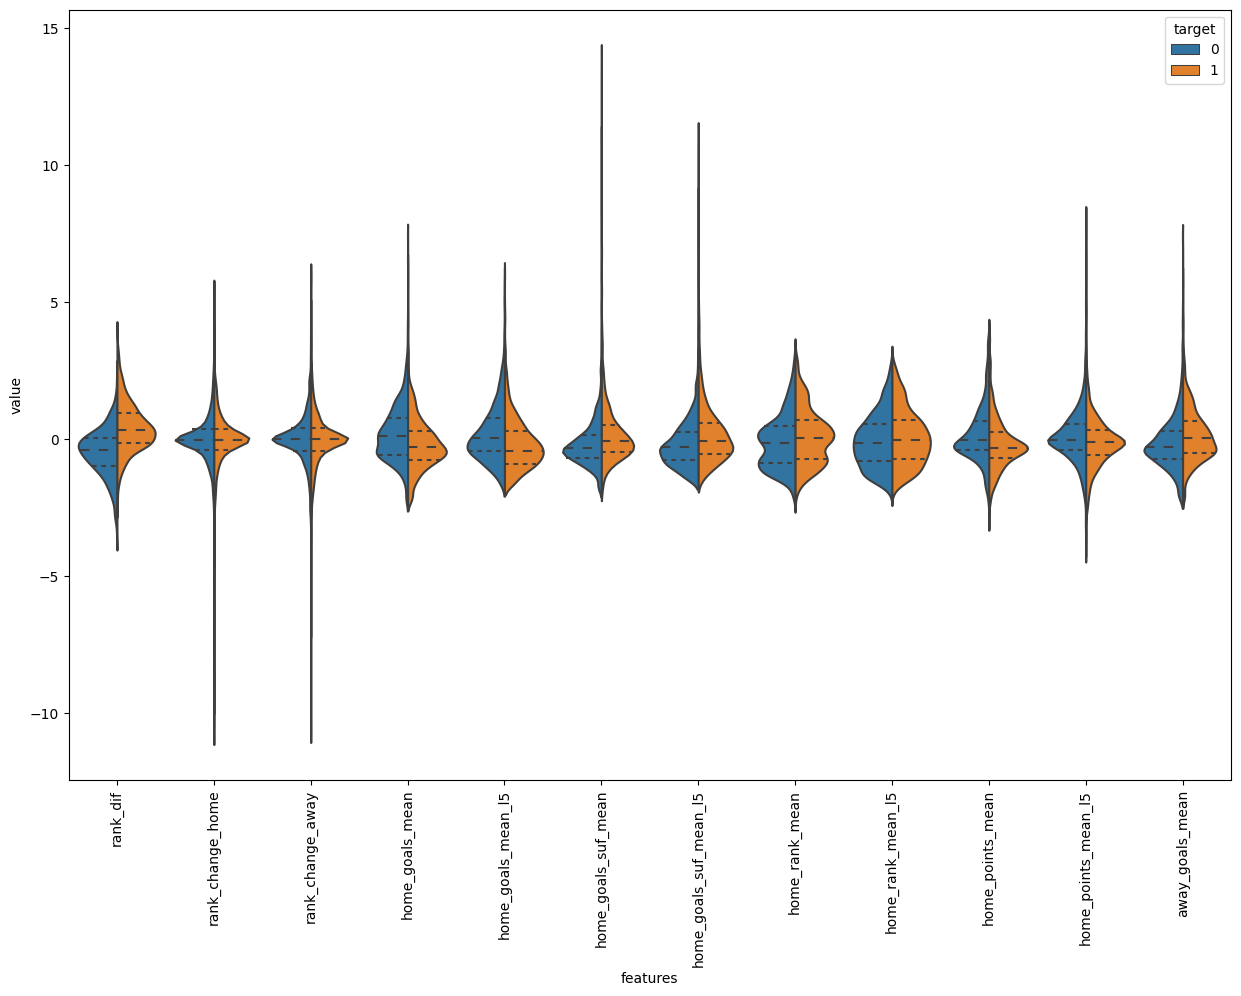

In [37]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

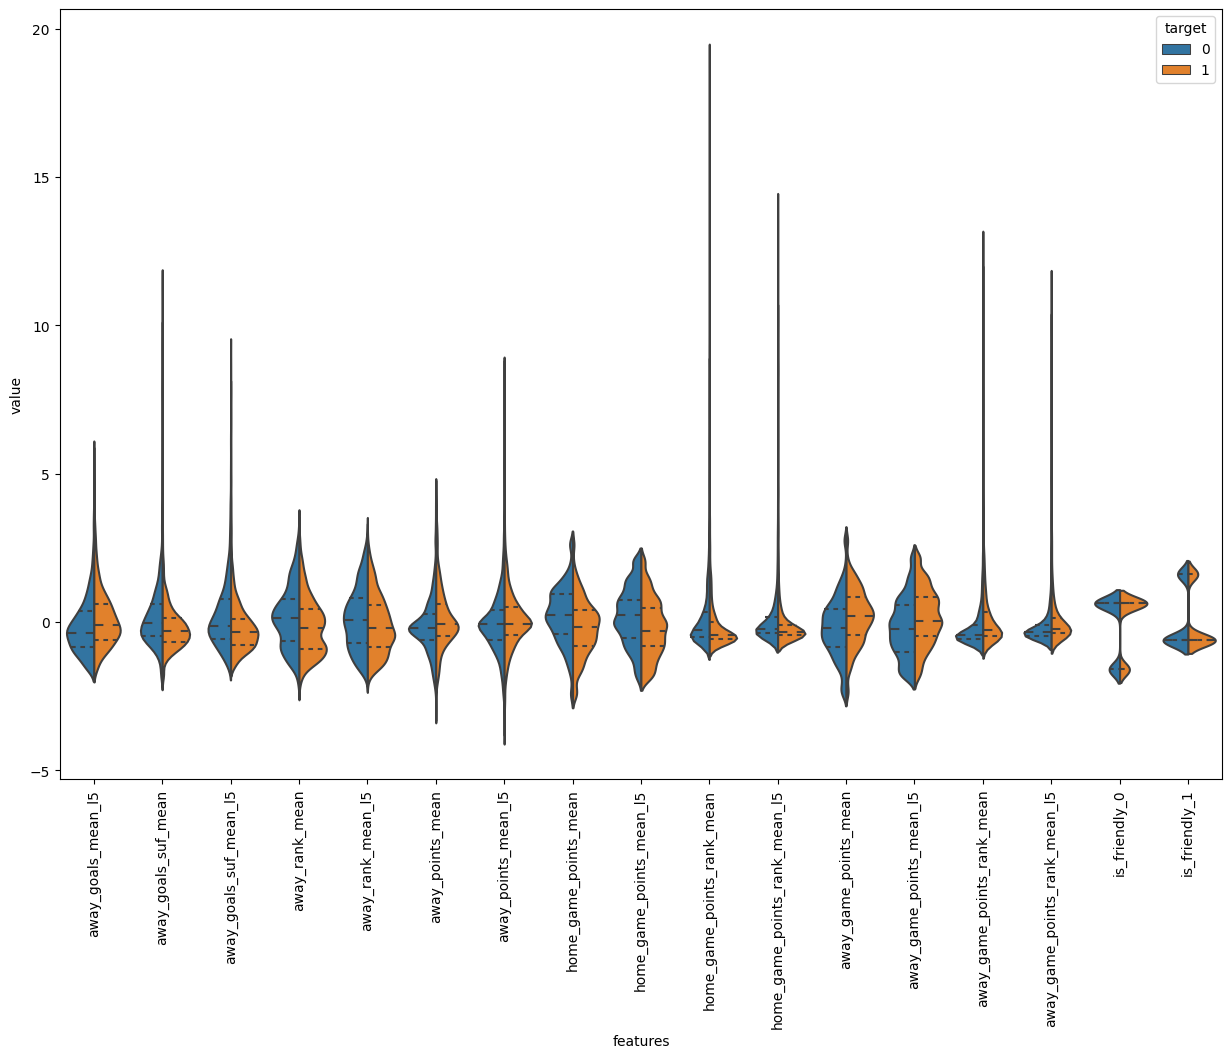

In [38]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Con los gráficos realizados, encontramos que la diferencia de rango es el único buen separador de los datos. Sin embargo, se pueden crear características que obtengan las diferencias entre el equipo local y el visitante y analizar si son buenas para separar los datos.

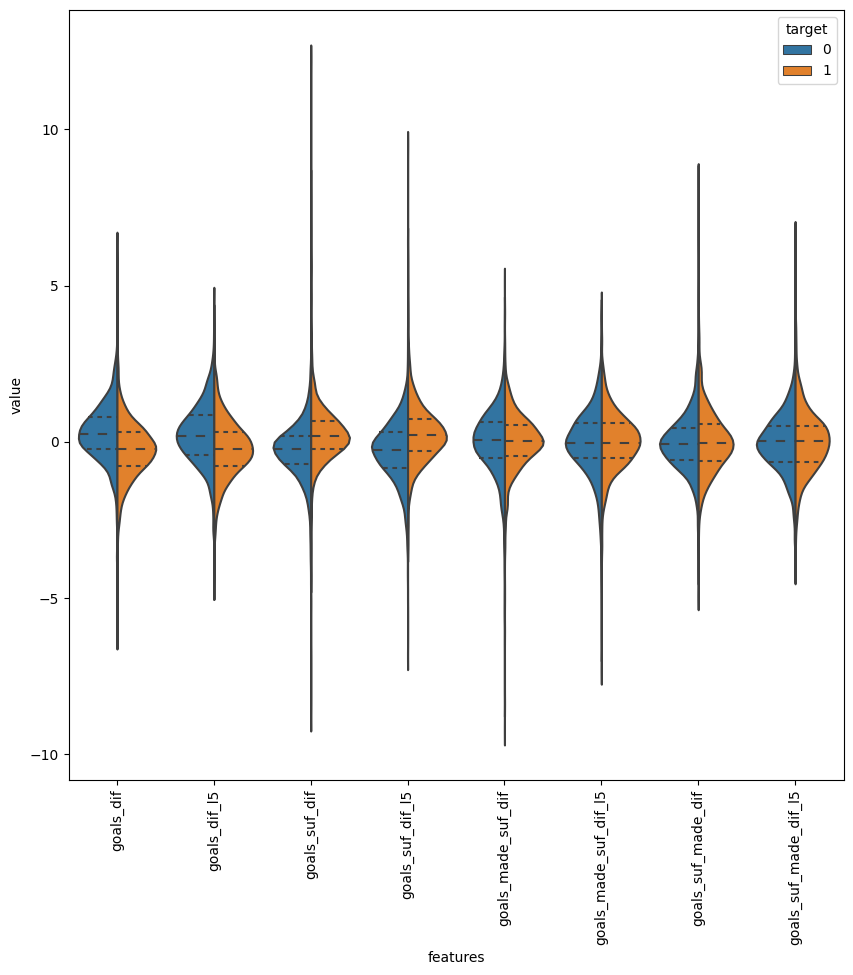

In [39]:
dif = df.copy()

dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Con este gráfico, se observa que las diferencias de goles son un buen separador, y que la diferencia de goles sufridos también. Las diferencias entre goles hechos y goles sufridos de los equipos no son muy buenos separadores.

Ahora, tenemos 5 características:

- rank_dif
- goles_dif
- goles_dif_l5
- goles_suf_dif
- goles_suf_dif_l5



In [40]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]

dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]

dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]

dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]

dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Además, se pueden calcular los goles marcados y los sufridos por rango, y comprobar esta diferencia.

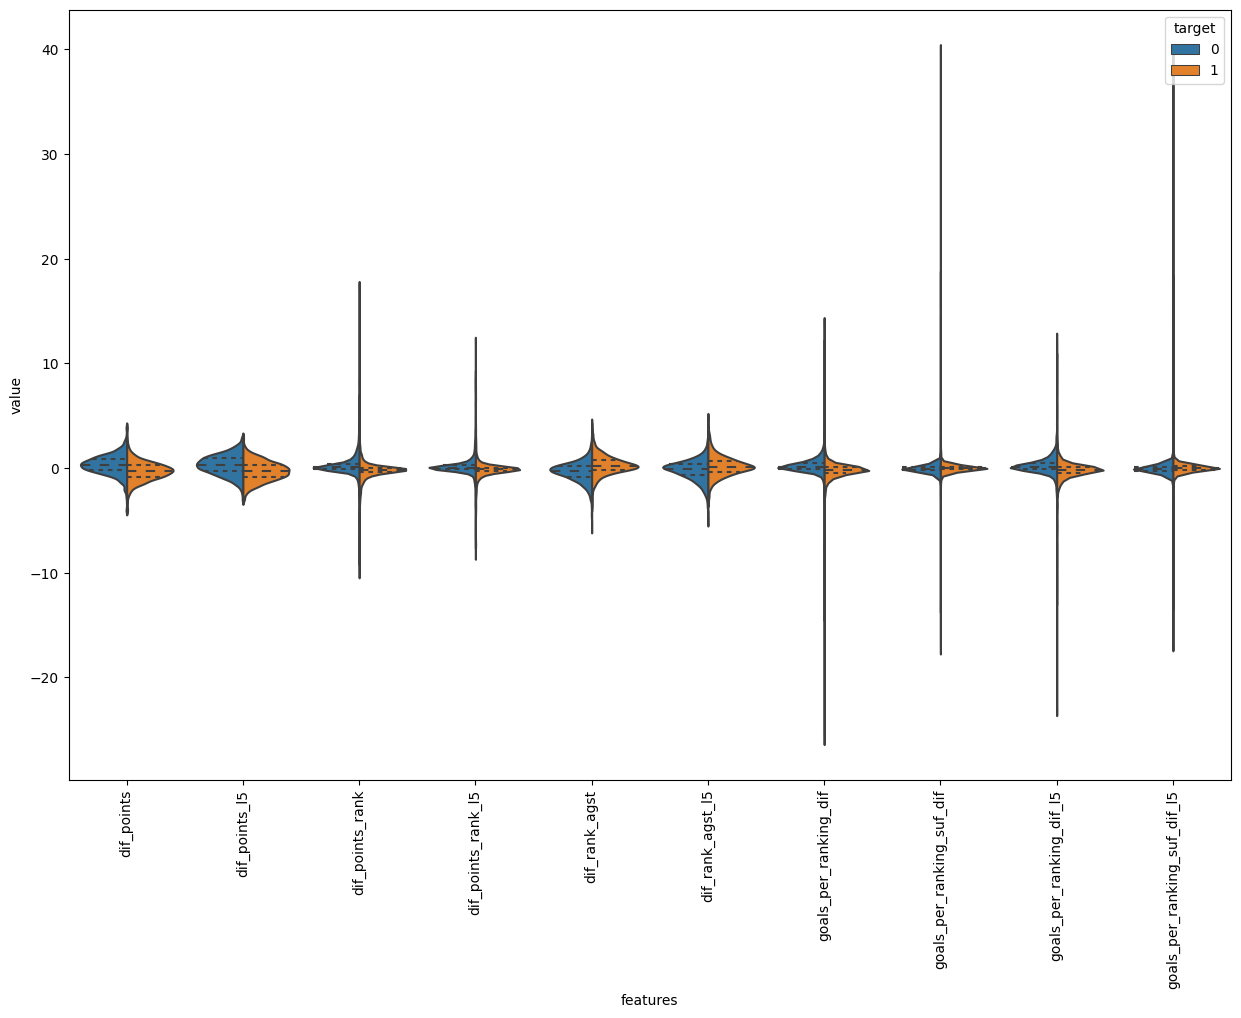

In [41]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])

dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])

dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])

dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

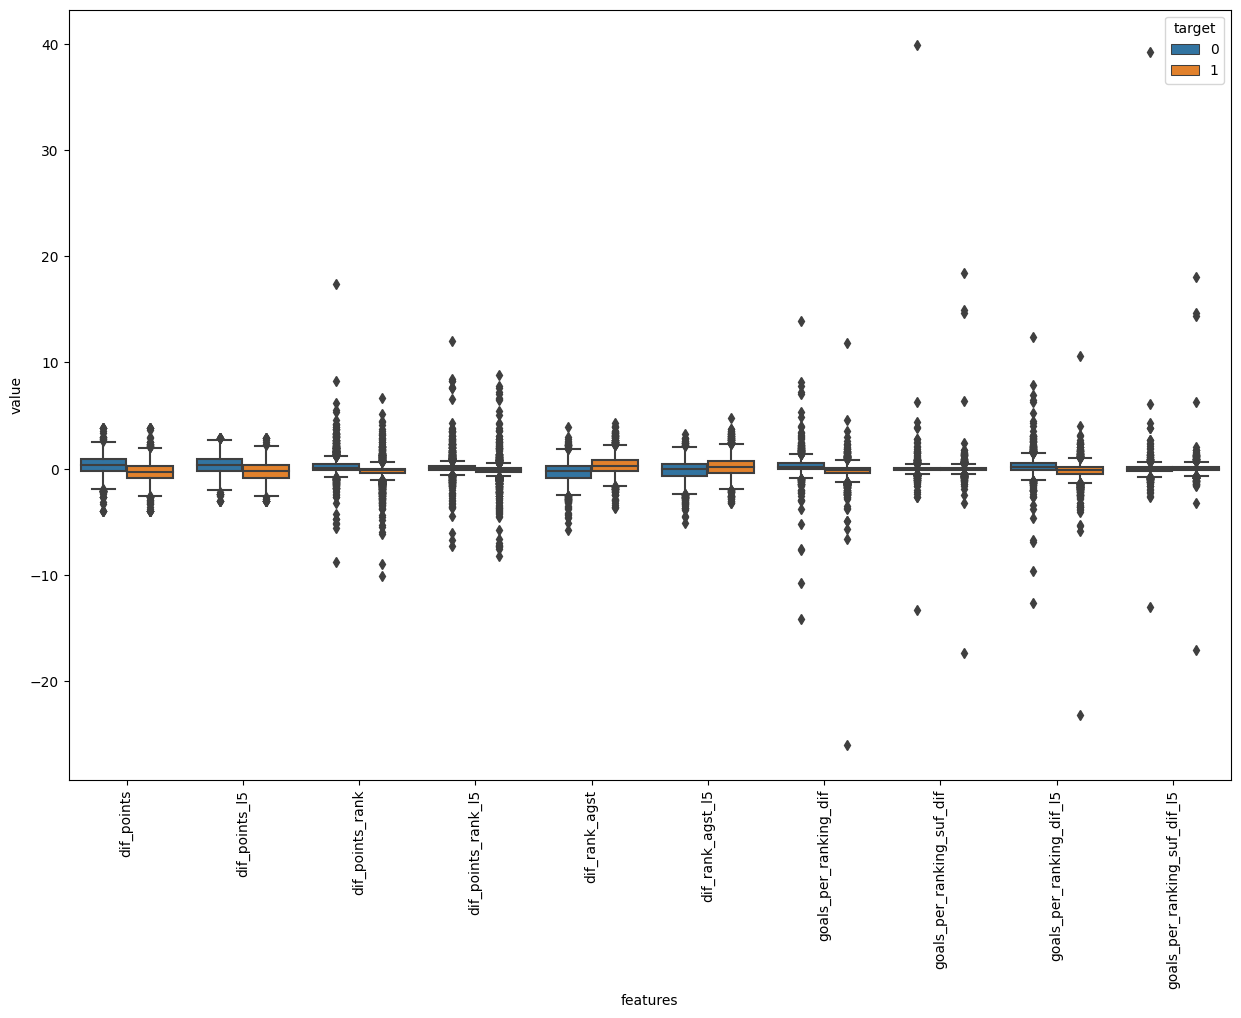

In [42]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

La diferencia de puntos (partidos completos y últimos 5), la diferencia de puntos por clasificación afrontada (partidos completos y últimos 5) y la diferencia de clasificación afrontada (partidos completos y últimos 5) son buenas características. Además, algunas de las características generadas tienen distribuciones muy similares que se analizarán mediante gráficos de dispersión.

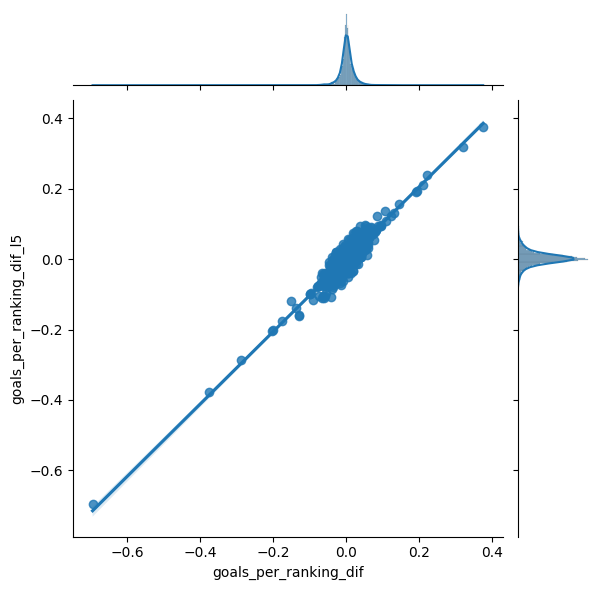

In [43]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

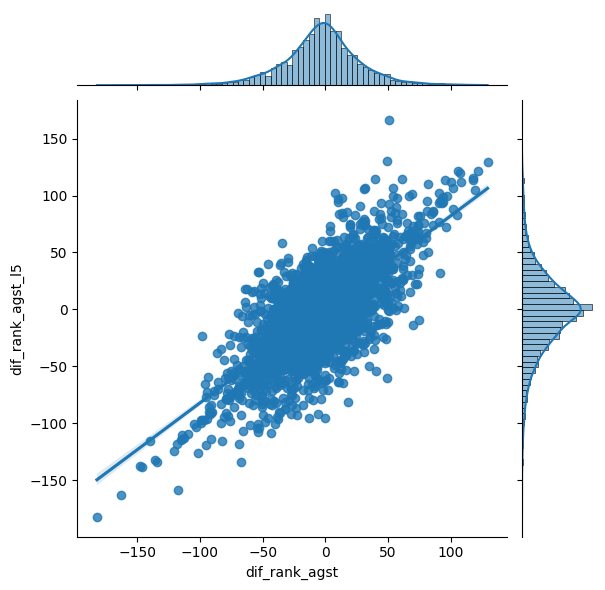

In [44]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

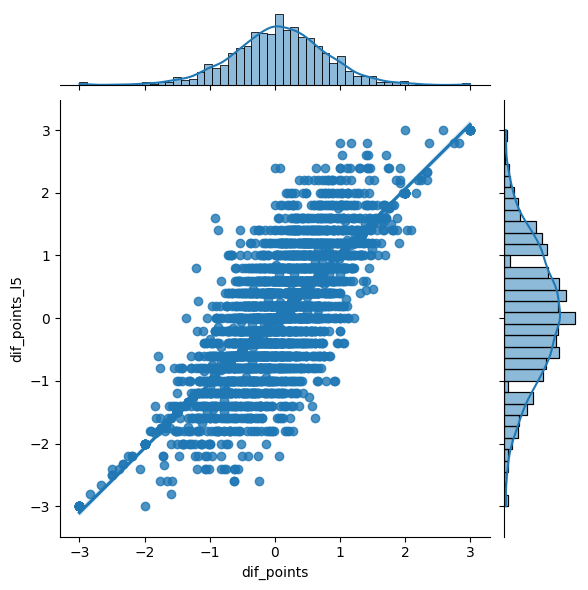

In [45]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

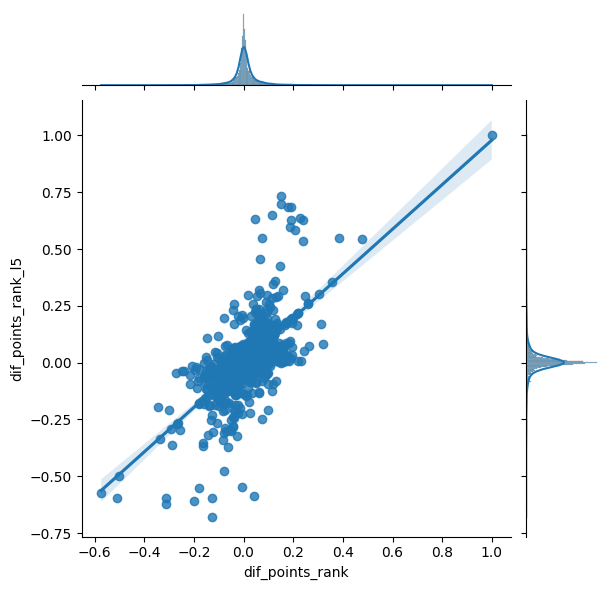

In [46]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

Para las diferencias de rango afrontado, puntos de juego por rango afrontado y media de puntos de juego por rango afrontado, las dos versiones (completa y 5 juegos) no son tan similares. Por lo tanto, se utilizarán ambas.

Basándonos en esto, las características finales son:

- rank_dif
- goles_dif
- goles_dif_l5
- metas_suf_dif
- goles_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [47]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [48]:
model_db = create_db(df)

model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
4,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
6,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
31,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
32,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
33,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489,Malaysia,Maldives,0,-8.0,0.767206,0.6,-0.534413,-0.8,0.006722,-16.485830,-19.6,0.004389,0.000855,0,1
3490,Vietnam,Philippines,0,-37.0,0.567778,1.8,-0.464444,-1.2,0.006699,-18.246667,-47.4,0.007125,0.017688,0,1
3491,Croatia,Morocco,0,-10.0,-0.025000,0.2,0.710227,0.6,0.017754,-32.061364,1.6,0.031571,-0.086905,1,0
3492,Singapore,Maldives,0,6.0,0.233716,0.0,-0.120051,0.0,0.003307,-24.234994,-38.8,0.002320,-0.002123,0,1


Ahora que se tiene una base de datos lista y con columnas con poder predictivo, se puede empezar con la modelización.

Se probarán dos modelos: Random Forest y Gradient Boosting. Se elegirá el que tenga mejor recall.

In [49]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [50]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [52]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [53]:
gb = gb_cv.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [54]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [55]:
rf = rf_cv.best_estimator_

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

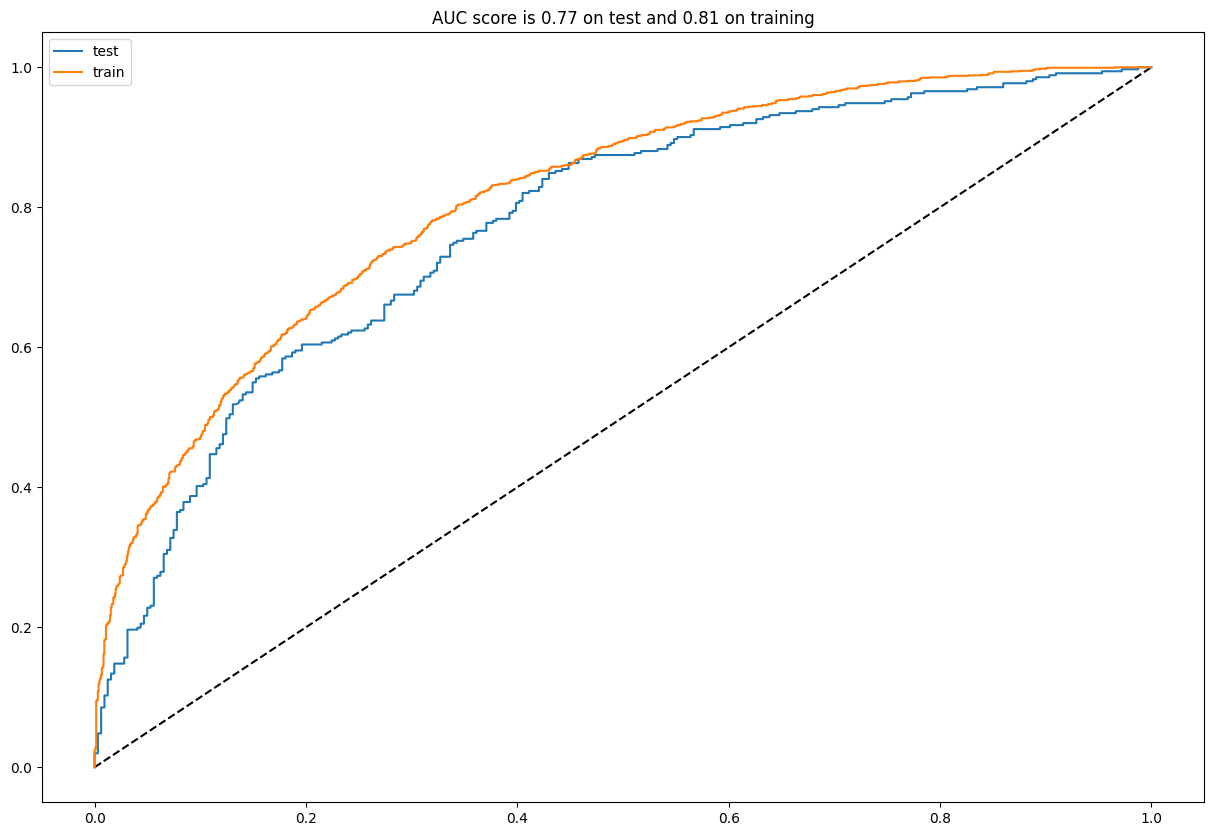

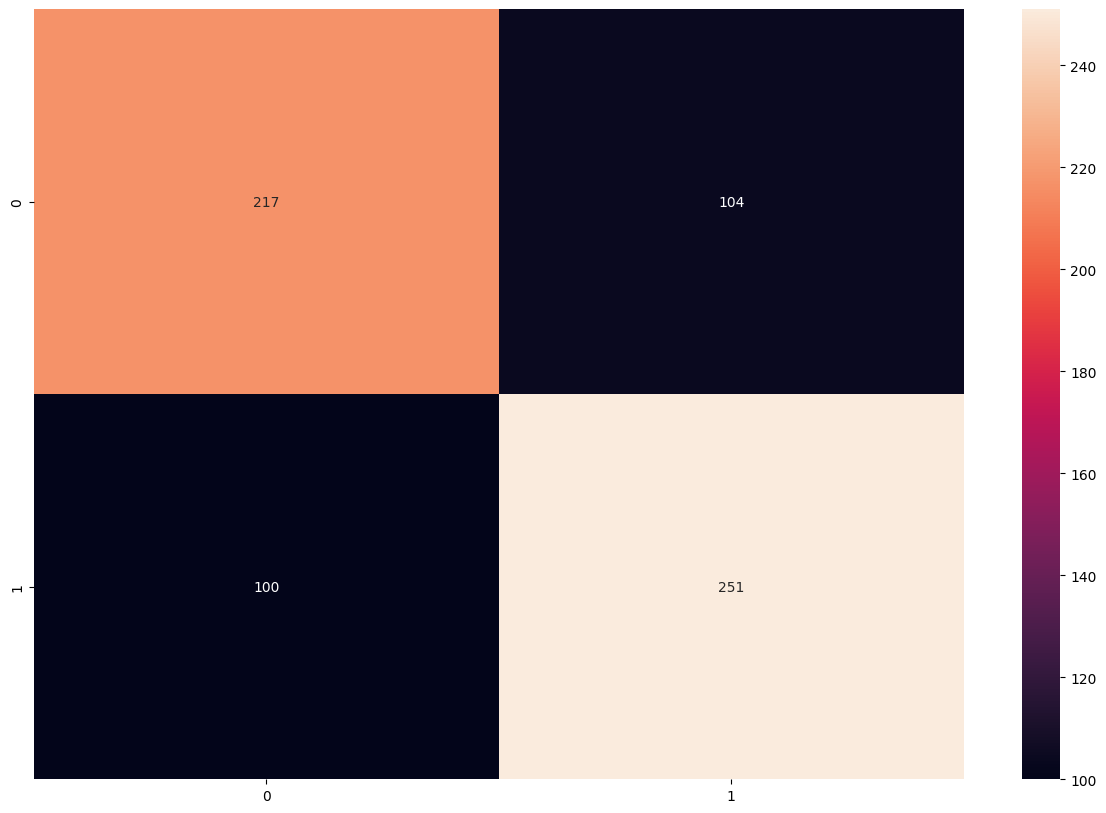

In [56]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")
    
analyze(gb)

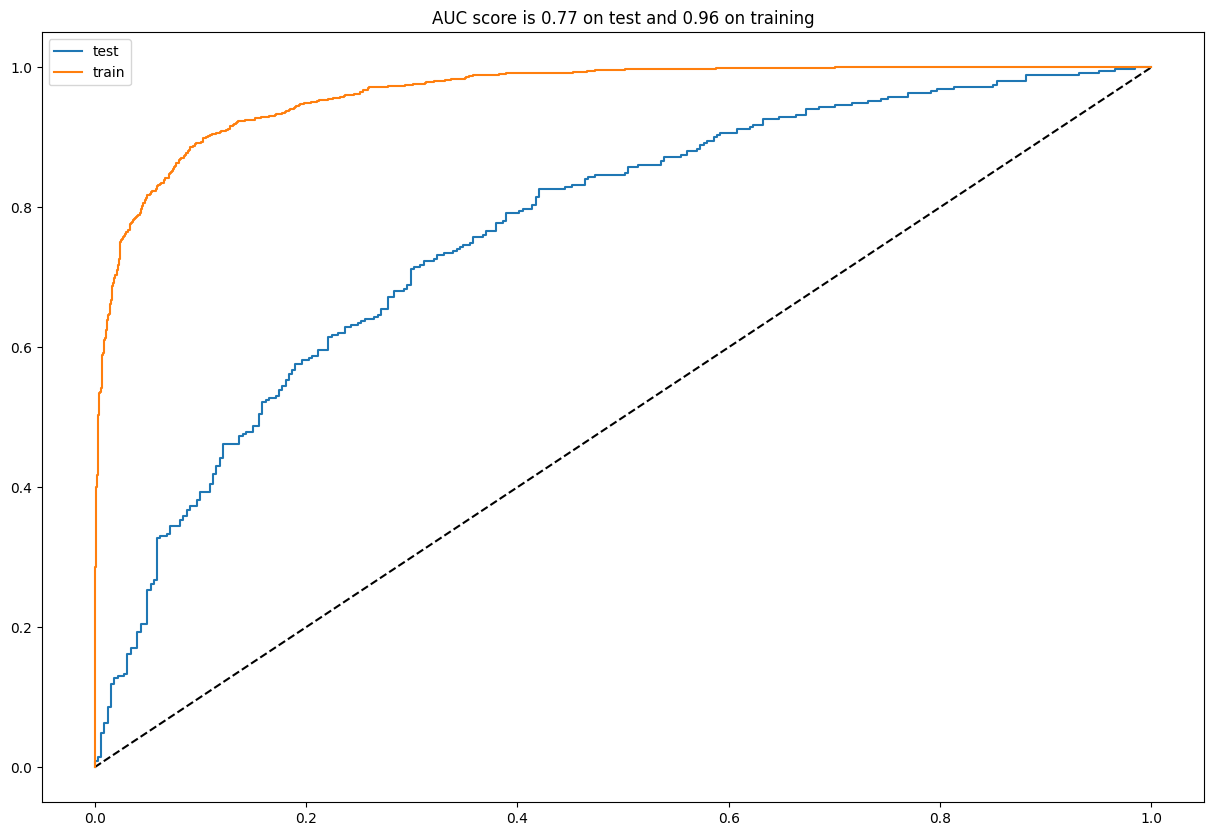

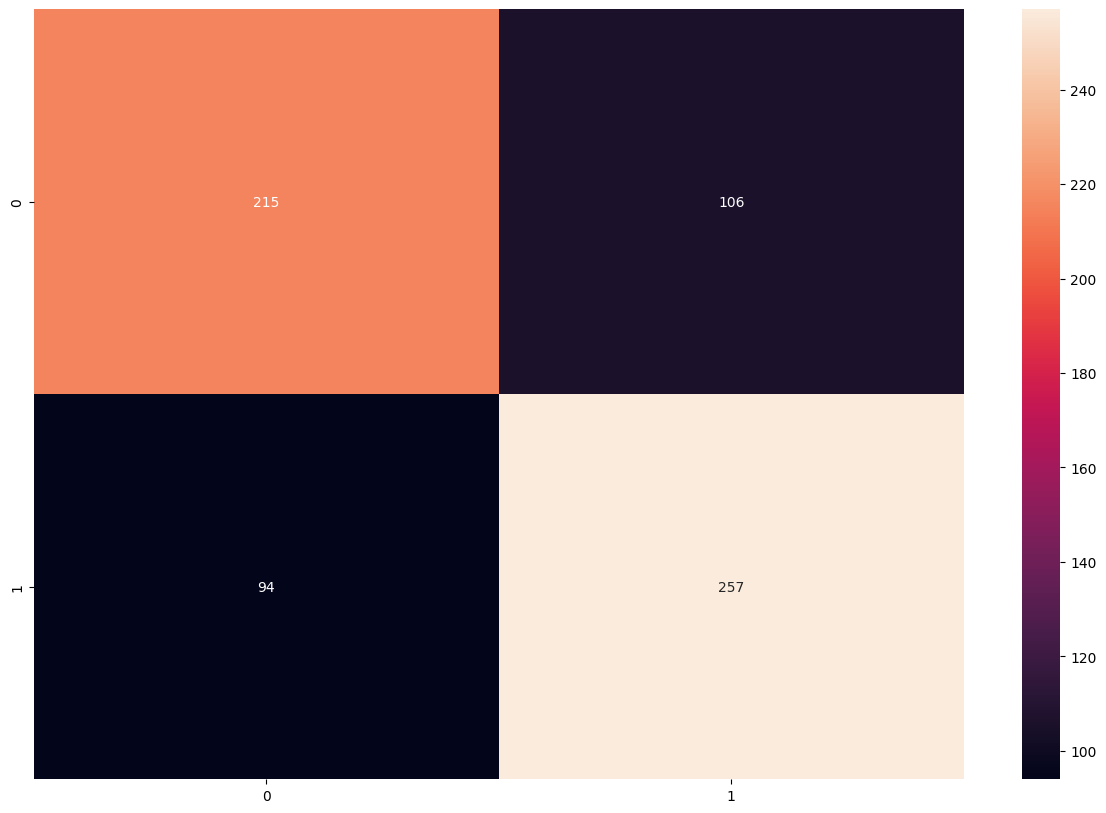

In [57]:
analyze(rf)

El modelo Random Forest es un poco mejor, pero parece no ajustarse bien. Por lo tanto, se utilizará el modelo Gradient Boosting.

In [58]:
from operator import itemgetter

Simulación del mundial de la FIFA 2022.

Primeramente se deben crear los partidos del mundial de la FIFA. Para esto, se va a obtener la información de wikipedia.

In [59]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
table = {'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}


import itertools as it
matches = []
for k in table:
    v = table[k]
    l = []
    for i in v:
        l.append(i[0])
    for e in it.combinations(l, 2):
        matches.append((k,e[0],e[1]))

In [61]:
table

{'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [62]:
matches

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Qatar', 'Netherlands'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Ecuador', 'Netherlands'),
 ('A', 'Senegal', 'Netherlands'),
 ('B', 'England', 'Iran'),
 ('B', 'England', 'United States'),
 ('B', 'England', 'Wales'),
 ('B', 'Iran', 'United States'),
 ('B', 'Iran', 'Wales'),
 ('B', 'United States', 'Wales'),
 ('C', 'Argentina', 'Saudi Arabia'),
 ('C', 'Argentina', 'Mexico'),
 ('C', 'Argentina', 'Poland'),
 ('C', 'Saudi Arabia', 'Mexico'),
 ('C', 'Saudi Arabia', 'Poland'),
 ('C', 'Mexico', 'Poland'),
 ('D', 'France', 'Australia'),
 ('D', 'France', 'Denmark'),
 ('D', 'France', 'Tunisia'),
 ('D', 'Australia', 'Denmark'),
 ('D', 'Australia', 'Tunisia'),
 ('D', 'Denmark', 'Tunisia'),
 ('E', 'Spain', 'Costa Rica'),
 ('E', 'Spain', 'Germany'),
 ('E', 'Spain', 'Japan'),
 ('E', 'Costa Rica', 'Germany'),
 ('E', 'Costa Rica', 'Japan'),
 ('E', 'Germany', 'Japan'),
 ('F', 'Belgium', 'Canada'),
 ('F', 'Belgium', 'Morocco'),
 ('F', 'Belgium',

In [63]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Se procede a realizar la simulación. Como el modelo simula si el equipo 1 ganará o no, es necesario crear algunos criterios para definir un empate. Además, como no se tiene la ventaja de jugar en casa en el Mundial, se va a predecir el partido dos veces, cambiando el equipo 1 y el equipo 2. El equipo con la media más alta de probabilidades será asignado como ganador. En la fase de grupos, si el "equipo local" gana como equipo 1 y pierde como equipo 2, o si el "equipo local" gana como equipo 2 y pierde como equipo 1, se asignará un empate en ese partido.

In [64]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.62 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.58 probability
Group A - Qatar vs. Netherlands: Winner Netherlands with 0.77 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Ecuador vs. Netherlands: Winner Netherlands with 0.72 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.67 probability


Group A advanced: 
Netherlands -------- 9
Ecuador -------- 4
Senegal -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.67 probability
Group B - England vs. United States: Winner England with 0.65 probability
Group B - England vs. Wales: Winner England with 0.69 probability
Group B - Iran vs. United States: Winner United States with 0.60 probability
Group B - Iran vs. Wales: Draw
Group B - United States vs. Wales: Draw


Group B advanced: 
England -------- 9
United

La fase de grupos esta predicha. 

In [65]:
advanced = advanced_group

playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [66]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.60
Argentina vs. Denmark: Argentina advances with prob 0.60
Spain vs. Croatia: Spain advances with prob 0.67
Brazil vs. Uruguay: Brazil advances with prob 0.69
Ecuador vs. England: England advances with prob 0.74
Poland vs. France: France advances with prob 0.66
Germany vs. Belgium: Germany advances with prob 0.52
Switzerland vs. Portugal: Portugal advances with prob 0.59
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Netherlands advances with prob 0.50
Spain vs. Brazil: Brazil advances with prob 0.56
England vs. France: England advances with prob 0.54
Germany vs. Portugal: Portugal advances with prob 0.55
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.56
England vs. Portugal: England advances with prob 0.61
----------
Starting simulation of Final
----------


Br

Predecimos las rondas finalds y el ganador que en este caso fue Brasil.

https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml/notebook